In [2]:
import pandas as pd

df = pd.read_csv(f"training_setA/p000001.psv", sep='|', header=0)
#df.drop(columns=["ICULOS"], inplace=True)
df["UCR"] = df["BUN"] / df["Creatinine"] # Urea-to-creatinine ratio
df["ShockIndex"] = df["HR"] / df["SBP"]

def sofa(mean_arterial_pressure: float, platelets: float, bilirubin: float, creatinine: float) -> int:
	score = 0

	if mean_arterial_pressure < 70:
		score += 1

	if platelets < 20:
		score += 4
	elif platelets < 50:
		score += 3
	elif platelets < 100:
		score += 2
	elif platelets < 150:
		score += 1

	if bilirubin > 12:
		score += 4
	elif bilirubin > 6:
		score += 3
	elif bilirubin > 2:
		score += 2
	elif bilirubin > 1.2:
		score += 1

	if creatinine > 5:
		score += 4
	elif creatinine > 3.5:
		score += 3
	elif creatinine > 2:
		score += 2
	elif creatinine > 1.2:
		score += 1

	return score

df["SOFA"] = df.apply(lambda row: sofa(row["MAP"], row["Platelets"], row["Bilirubin_total"], row["Creatinine"]), axis=1)

df_forward_fill = df.ffill(inplace=False)
df_backward_fill = df.bfill(inplace=False)
df_interpolated = df.interpolate(inplace=False)
print(df.shape)

(54, 44)


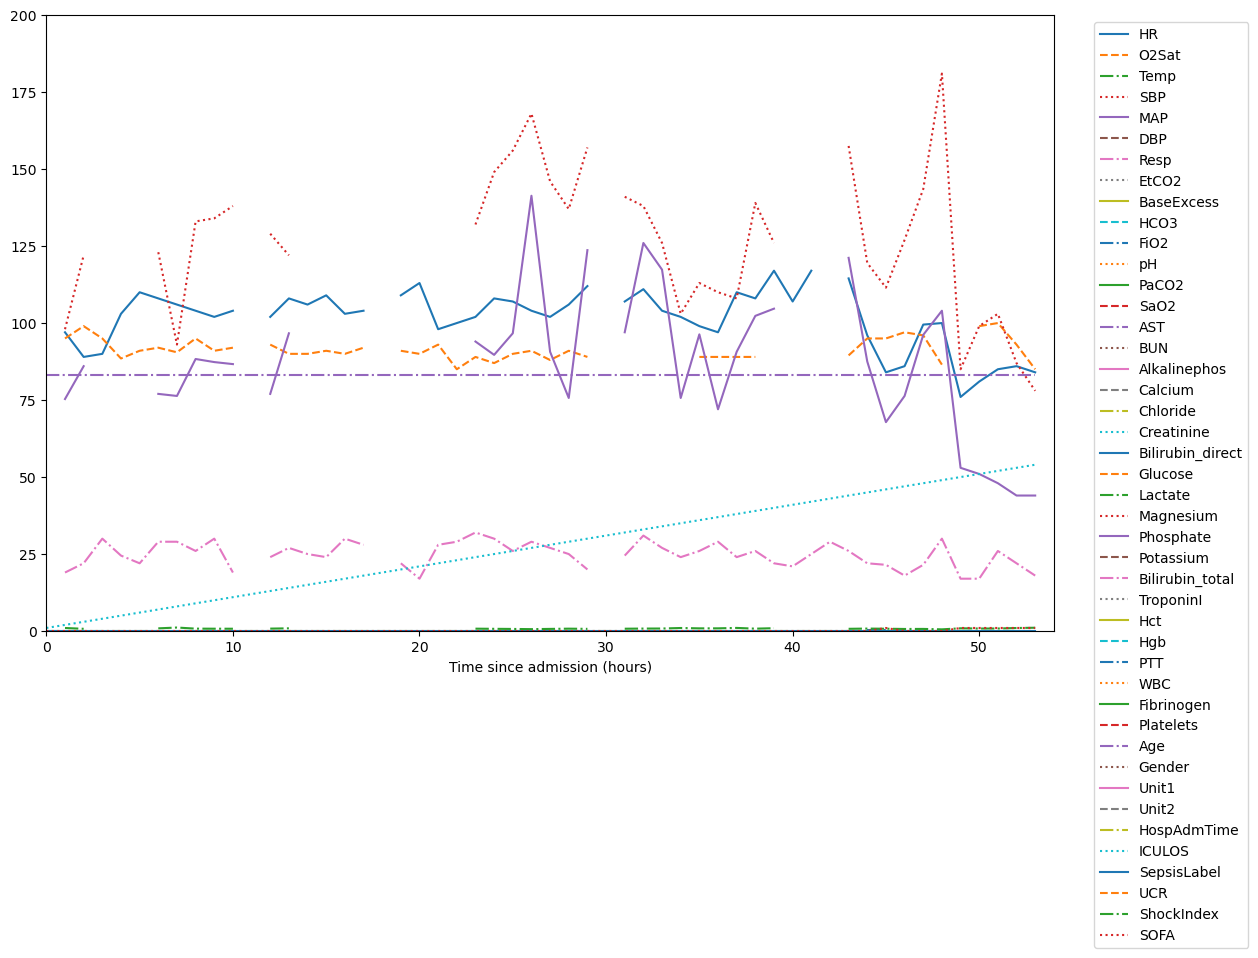

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

NUM_COLORS = df.shape[1]
LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
NUM_STYLES = len(LINE_STYLES)

sns.reset_orig()  # get default matplotlib styles back
clrs = sns.color_palette('husl', n_colors=NUM_COLORS)  # a list of RGB tuples
fig, ax = plt.subplots(1)

for i, column in enumerate(df.columns):
	lines = ax.plot(df.index, df[column], label=column)
	lines[0].set_linestyle(LINE_STYLES[i % NUM_STYLES])

fig.set_size_inches((13, 8))
plt.ylim((0, 200))
plt.xlim((0, df.shape[0]))
plt.xlabel("Time since admission (hours)")
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

In [7]:
import numpy as np
import iisignature
from pprint import pprint

stream = np.copy(df["ICULOS"].squeeze(axis=0).to_numpy(dtype=int).reshape((-1, 1)))
for column in df_backward_fill:
	stream = np.append(stream, df_backward_fill[column].squeeze(axis=0).to_numpy(dtype=float).reshape((-1, 1)), axis=1)

signature = iisignature.sig(stream, 4)
pprint(signature.shape)

(4193820,)
